# Fall 2022 Data Science Intern Challenge

Question 1: Given some sample data, write a program to answer the following: click here to access the required data set
On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one model of shoe. We want to do some analysis of the average order value (AOV). When we look at orders data over a 30 day window, we naively calculate an AOV of $3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis.

1. Think about what could be going wrong with our calculation. Think about a better way to evaluate this data.
2. What metric would you report for this dataset?
3. What is its value?

## Approach

- Figure out the appraoch used to calculate AOV
- Investigate data to see it's distribution and other summary statistics
- Evaluate different metrics for AOV (median, quantiles)
- Decide on best metric

## Setup

In [193]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
from scipy.stats import binom
import matplotlib.pyplot as plt

In [194]:
df = pd.read_csv('dataset.csv')
print(df.shape)
df.head()

(5000, 7)


,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


## Original AOV Approach

In [195]:
round(df.order_amount.mean(), 2)

3145.13

The team used the average order amount as their AOV metric. This is a natural measurement because it is easy to calculate and communicate. The drawback when using it as a metric for large datasets is that it is easily distorted when the data is either skewed or contains outliers. I'm willing to bet that is the case here. Let's take a look.

## EDA

Let's quickly check for missing values in the dataset

In [196]:
df.isnull().sum()

order_id          0
shop_id           0
user_id           0
order_amount      0
total_items       0
payment_method    0
created_at        0
dtype: int64

There are no missing values. (yay!)

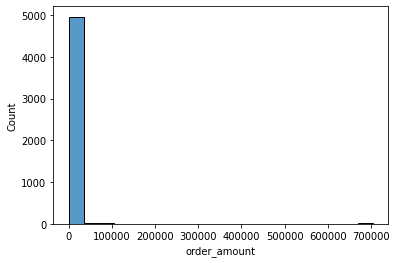

In [197]:
sns.histplot(x="order_amount", bins=20, data=df)
plt.show()

It is a little hard to see anything due to the range of values present in `order_amount`. We can fix this by using a log scale for the x-axis.

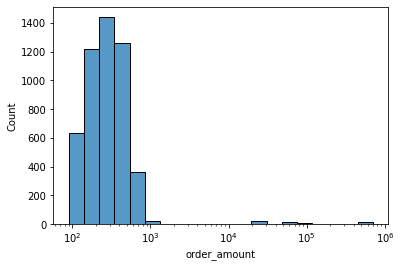

In [198]:
sns.histplot(x="order_amount", log_scale=True, bins=20, data=df)
plt.show()

It is clear order values contains a few outliers. Most of the data is falls between 100-1000$, but some order amounts are in the tens or even hundread of thousands. Let's take a look at the quantiles.

In [199]:
d = {'percentile': [.1, .25, .5, .75, .9, .98, .99, 1]}
quantile_df = pd.DataFrame(data=d)
quantile_df['order_amount'] = quantile_df['percentile'].apply(lambda q: df['order_amount'].quantile(q))
quantile_df

,percentile,order_amount
0,0.10,133.00
1,0.25,163.00
2,0.50,284.00
3,0.75,390.00
4,0.90,531.00
5,0.98,800.08
6,0.99,25725.00
7,1.00,704000.00


Takeaways from percentile table:
- 284$ is the median order amount.
- 50% of orders are between 163$ and 390$
- 98% of orders are below 800.08$
- The highest order value in our dataset is 704,000$ (an extreme outlier)

### Assumptions

1. All order amounts are represented in USD
2. Each shop sells one model of shoe at the same price
3. There are no discounts or other price alterations applied to these orders
4. Each `user_id`, `order_id`, `shop_id` are unique and represent one user, order, and shop, respectively.
5. Dataset contains no nulls (verified above)

### Examining the outliers

In [200]:
print(df[df['order_amount'] == 704000].shape)
df[df['user_id'] == 607]

(17, 7)


,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
15,16,42,607,704000,2000,credit_card,2017-03-07 4:00:00
60,61,42,607,704000,2000,credit_card,2017-03-04 4:00:00
520,521,42,607,704000,2000,credit_card,2017-03-02 4:00:00
1104,1105,42,607,704000,2000,credit_card,2017-03-24 4:00:00
1362,1363,42,607,704000,2000,credit_card,2017-03-15 4:00:00
1436,1437,42,607,704000,2000,credit_card,2017-03-11 4:00:00
1562,1563,42,607,704000,2000,credit_card,2017-03-19 4:00:00
1602,1603,42,607,704000,2000,credit_card,2017-03-17 4:00:00
2153,2154,42,607,704000,2000,credit_card,2017-03-12 4:00:00
2297,2298,42,607,704000,2000,credit_card,2017-03-07 4:00:00


In [201]:
high_value_shops

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
15,16,42,607,704000,2000,credit_card,2017-03-07 4:00:00
60,61,42,607,704000,2000,credit_card,2017-03-04 4:00:00
160,161,78,990,25725,1,credit_card,2017-03-12 5:56:57
490,491,78,936,51450,2,debit,2017-03-26 17:08:19
493,494,78,983,51450,2,cash,2017-03-16 21:39:35
...,...,...,...,...,...,...,...
4646,4647,42,607,704000,2000,credit_card,2017-03-02 4:00:00
4715,4716,78,818,77175,3,debit,2017-03-05 5:10:44
4868,4869,42,607,704000,2000,credit_card,2017-03-22 4:00:00
4882,4883,42,607,704000,2000,credit_card,2017-03-25 4:00:00


In [1]:
high_value_order = df[df['order_amount'] >= 25725]
rows, cols = high_value_order.shape
high_value_order_mean = high_value_order.order_amount.mean()
print(f'There are {rows} orders exceeding the 99th percentile.')
print(f'The average order amount for these orders is {high_value_order_mean:.2f}$')
print('Counts of unique order amounts')
print(high_value_order.order_amount.value_counts())
print('Count of unique shops')
print(high_value_order.shop_id.value_counts())
print('Count of unique users')
print(high_value_order.user_id.value_counts())

NameError: name 'df' is not defined

Takeaways
- There are 63 orders at or above our 99th percentile mark (25,725$)
- 2 shops are responsible for all orders at or above the 99th percentile mark
- shop id (78) sells sneakers at 25,725$
- user id (607) only has bulk purchases from shop id (42) totalling 704,000$ per order (2000 units @ 352$).

We will exclude shop id (78) and user id (607) from the remainder of our analysis since they are ill-representative of a "typical" order. The two are outliers and should be analyzed seperately.

In [203]:
user_to_exclude = 607
shop_to_exclude = 78
shops = df[(df['shop_id'] != shop_to_exclude)]
shops = shops[(shops['user_id'] != user_to_exclude)]

In [204]:
unique_shops = shops.shop_id.nunique()
rows, cols = shops.shape

print(f'We have {unique_shops} shop ids left in our dataset')
print(f'We have {rows} rows in our datset')

We have 99 shop ids left in our dataset
We have 4937 rows in our datset


Now, let's examine the distribution of the data

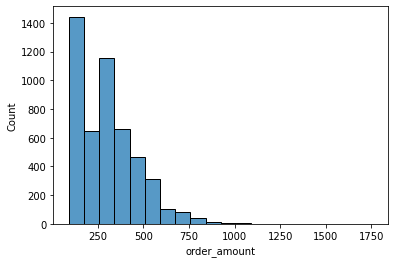

In [205]:
sns.histplot(x="order_amount", bins=20, data=shops)
plt.show()

## New Metric

There are a few different metrics to examine:
- mean
- median
- percentiles
- bootstrapped percentiles

In [210]:
round(shops.order_amount.mean(), 2)

302.58

In [211]:
round(shops.order_amount.median(), 2)

284.0

In [212]:
d = {'percentile': [.1, .25, .5, .75, .9, .98, .99, 1]}
quantile_df = pd.DataFrame(data=d)
quantile_df['order_amount'] = quantile_df['percentile'].apply(lambda q: shops['order_amount'].quantile(q))
quantile_df

,percentile,order_amount
0,0.10,133.0
1,0.25,163.0
2,0.50,284.0
3,0.75,387.0
4,0.90,520.0
5,0.98,710.0
6,0.99,780.0
7,1.00,1760.0


In [213]:
def simulate_sample_median(df):
    sample = df.sample(frac=.9, replace=True).order_amount
    return sample.median()

In [220]:
number_of_bootstrap_samples=10000
sample_medians = (
    [simulate_sample_median(shops) 
    for _ in tqdm(range(number_of_bootstrap_samples), ascii=True)]
)


























































































































































































































































































































































































































































































































































































































































































100%|##########| 10000/10000 [00:17<00:00, 555.65it/s]


In [221]:
sample_medians = np.array(sample_medians)
outcome_sorted = np.sort(sample_medians)
alpha=0.01
quantile_of_interest=0.5
sample_size=np.shape(sample_medians)[0]

ci_indexes = binom.ppf([alpha/2,1-alpha/2],sample_size+1, quantile_of_interest)
bootstrap_confidence_interval = outcome_sorted[[int(np.floor(ci_indexes[0])), int(np.ceil(ci_indexes[1]))]]


f"The sample median using the reduced dataset is {np.quantile(outcome_sorted, quantile_of_interest)}, the {(1-alpha)*100}% \
confidence interval is given by ({bootstrap_confidence_interval})."

'The sample median using the reduced dataset is 284.0, the 99.0% confidence interval is given by ([284. 284.]).'

In [216]:
sample_medians = (
    [simulate_sample_median(df) 
    for i in tqdm(range(number_of_bootstrap_samples))]
)

In [217]:
sample_medians = np.array(sample_medians)
outcome_sorted = np.sort(sample_medians)
alpha=0.01
quantile_of_interest=0.5
sample_size=np.shape(sample_medians)[0]

ci_indexes = binom.ppf([alpha/2,1-alpha/2],sample_size+1, quantile_of_interest)
bootstrap_confidence_interval = outcome_sorted[[int(np.floor(ci_indexes[0])), int(np.ceil(ci_indexes[1]))]]

f"The sample median using the entire dataset is {np.quantile(outcome_sorted, quantile_of_interest)}, the {(1-alpha)*100}% \
confidence interval is given by ({bootstrap_confidence_interval})."

'The sample median using the entire dataset is 284.0, the 99.0% confidence interval is given by ([284. 284.]).'

- The mean is still a poor metric for AOV due to skewed data
- The median (50th percentile) of our reduced dataset, entire dataset, reduced dataset bootstrapped sample, and entire dataset bootstrapped sample gives the same result of 284$.

## Final Recommendation

After examining the data and testing different metrics, I would recommend using the bootstrap sample median as the AOV.

1. Think about what could be going wrong with our calculation. Think about a better way to evaluate this data.
- A potential mistake in the team's original calculation of AOV could have been that they did not check for outliers or the data's distribution. Since the arithmatic mean weights each point equally, outliers can drag the mean up or down. In this instance, we have extreme outliers pulling the mean up.

2. What metric would you report for this dataset?
- I would report a bootstrap sample median as the AOV of this dataset.
1. What is its value?
- Using bootstrap sample median, we find the AOV to be 284$.

## Question 2

1. How many orders were shipped by Speedy Express in total?
- 54 orders were shipped by Speedy Express
2. What is the last name of the employee with the most orders?
- Peacock is the last name of the employee with the most orders with 40 orders.
3. What product was ordered the most by customers in Germany?
- Boston Crab Cakes were ordered the most with 160 units sold.

-- a. How many orders were shipped by Speedy Express in total?

SELECT s.ShipperName as [Shipper Name], COUNT(*) as [Orders Shipped]  
FROM [Orders] o  
LEFT JOIN [Shippers] s ON o.ShipperID=s.ShipperID  
WHERE s.ShipperName = 'Speedy Express'
;

-- 54

-----------------------------------------------------------------

-- b. What is the last name of the employee with the most orders?

SELECT e.LastName as [Employee Last Name], COUNT(*) as [Orders Count]  
FROM [Orders] o  
LEFT JOIN [Employees] e ON o.EmployeeID=e.EmployeeID  
GROUP BY o.EmployeeID  
ORDER BY [Orders Count] DESC  
LIMIT 1  
;

-- Peacock

-----------------------------------------------------------------

-- c. What product was ordered the most by customers in Germany?

WITH german_purchases AS (  
    SELECT p.ProductName, od.Quantity  
    FROM [OrderDetails] od  
    LEFT JOIN [Orders] o ON od.OrderID=o.OrderID  
    LEFT JOIN [Products] p ON od.ProductID=p.ProductID  
    LEFT JOIN [Customers] c ON o.CustomerID=c.CustomerID  
    WHERE c.Country = 'Germany'  
)

SELECT ProductName as [Product Name], SUM(Quantity) as [Units Sold]  
FROM german_purchases  
GROUP BY ProductName  
ORDER BY [Units Sold] DESC  
LIMIT 1  
;

-- Boston Crab Meat